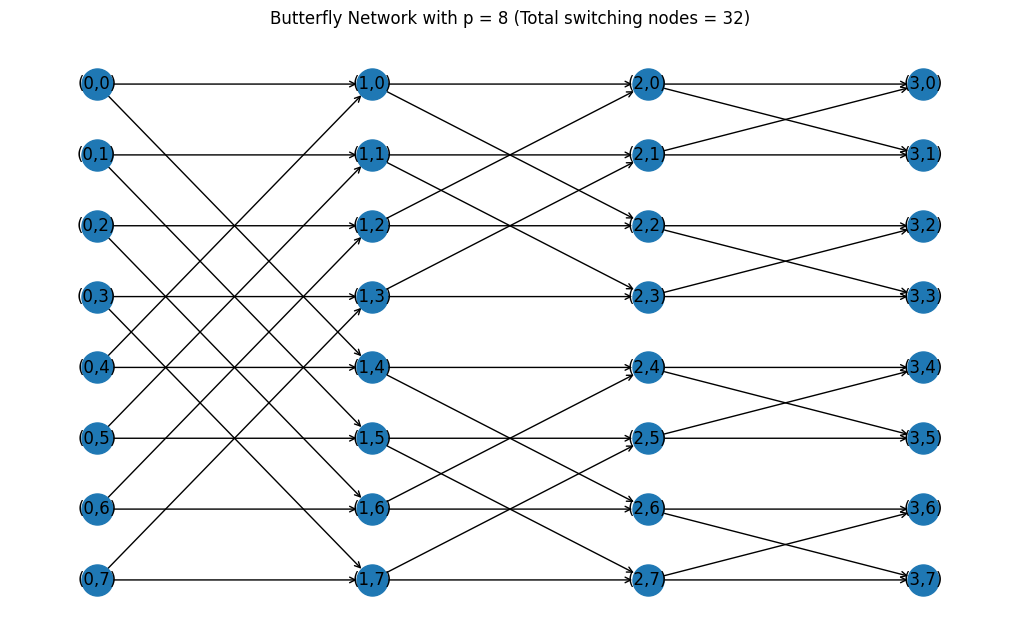

In [40]:
import math
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------------------------
# Packet class (same as before, for completeness)
# ------------------------------------------------
class Packet:
    """
    Packet with a 32-bit route_location, an optional payload, and a valid bit.
    """
    def __init__(self, route_location: int, payload=None, valid=True):
        self.route_location = route_location & 0xFFFFFFFF
        self.payload = payload
        self.valid = valid

    def __repr__(self):
        return f"Packet(dest={self.route_location}, payload={self.payload}, valid={self.valid})"

# ------------------------------------------------
# Butterfly Network Generation based on your logic
# ------------------------------------------------
def generate_butterfly_network(p):
    """
    Generate a butterfly network with p processor nodes.
    The network has p*(log2(p)+1) switching nodes arranged in ranks 0 to L,
    where L = log2(p). Each node is labeled as (i, j) where i is the rank and
    j is the column number (0 <= j < p).

    For any node N(i, j) with i > 0, add connections from:
      - N(i-1, j)
      - N(i-1, m), where m is computed by flipping the bit at position (L - i) in j.
    """
    L = int(math.log2(p))
    total_ranks = L + 1  # Ranks 0 through L
    G = nx.DiGraph()
    
    # Add all switching nodes: (rank, j) for rank in 0...L and j in 0...p-1
    for i in range(total_ranks):
        for j in range(p):
            node = (i, j)
            G.add_node(node, label=f"({i},{j})")
    
    # For every node in rank i>0, add edges from two nodes in the previous rank.
    for i in range(1, total_ranks):
        for j in range(p):
            # Compute the bit position to flip: (L - i)
            flip_bit = 1 << (L - i)
            j_flipped = j ^ flip_bit  # Flip the specified bit in j.
            # Connect from both N(i-1, j) and N(i-1, j_flipped) to N(i, j)
            G.add_edge((i-1, j), (i, j))
            G.add_edge((i-1, j_flipped), (i, j))
    return G

# ------------------------------------------------
# Visualization with networkx
# ------------------------------------------------
def draw_butterfly_network(G, p):
    """
    Draw the butterfly network graph G using a layered layout.
    Nodes are positioned by their rank (x coordinate) and column j (y coordinate).
    """
    pos = {}
    # Position nodes: x = rank, y = -j (so j=0 is at the top)
    for node in G.nodes():
        i, j = node
        pos[node] = (i, -j)
    
    labels = nx.get_node_attributes(G, 'label')
    
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=500,
            arrowstyle="->", arrowsize=10)
    plt.title(f"Butterfly Network with p = {p} (Total switching nodes = {p * (int(math.log2(p)) + 1)})")
    plt.xlabel("Rank")
    plt.ylabel("Column (j)")
    plt.show()

# ------------------------------------------------
# Example: Build and visualize a butterfly network for p = 8
# ------------------------------------------------
p = 8
G = generate_butterfly_network(p)
draw_butterfly_network(G, p)


Input Packets:
  Injected at node (0,0): Packet(dest=0, payload=Data_from_0, valid=True)
  Injected at node (0,1): Packet(dest=1, payload=Data_from_1, valid=True)
  Injected at node (0,2): Packet(dest=6, payload=Data_from_2, valid=True)
  Injected at node (0,3): Packet(dest=5, payload=Data_from_3, valid=True)
  Injected at node (0,4): Packet(dest=7, payload=Data_from_4, valid=True)
  Injected at node (0,5): Packet(dest=2, payload=Data_from_5, valid=True)
  Injected at node (0,6): Packet(dest=3, payload=Data_from_6, valid=True)
  Injected at node (0,7): Packet(dest=4, payload=Data_from_7, valid=True)

Routing Results:
Packet destined for 0 routed along path: [(0, 0), (1, 0), (2, 0), (3, 0)] --> Final Node: (3, 0)
Packet destined for 1 routed along path: [(0, 1), (1, 1), (2, 1), (3, 1)] --> Final Node: (3, 1)
Packet destined for 6 routed along path: [(0, 2), (1, 6), (2, 6), (3, 6)] --> Final Node: (3, 6)
Packet destined for 5 routed along path: [(0, 3), (1, 7), (2, 5), (3, 5)] --> Final 

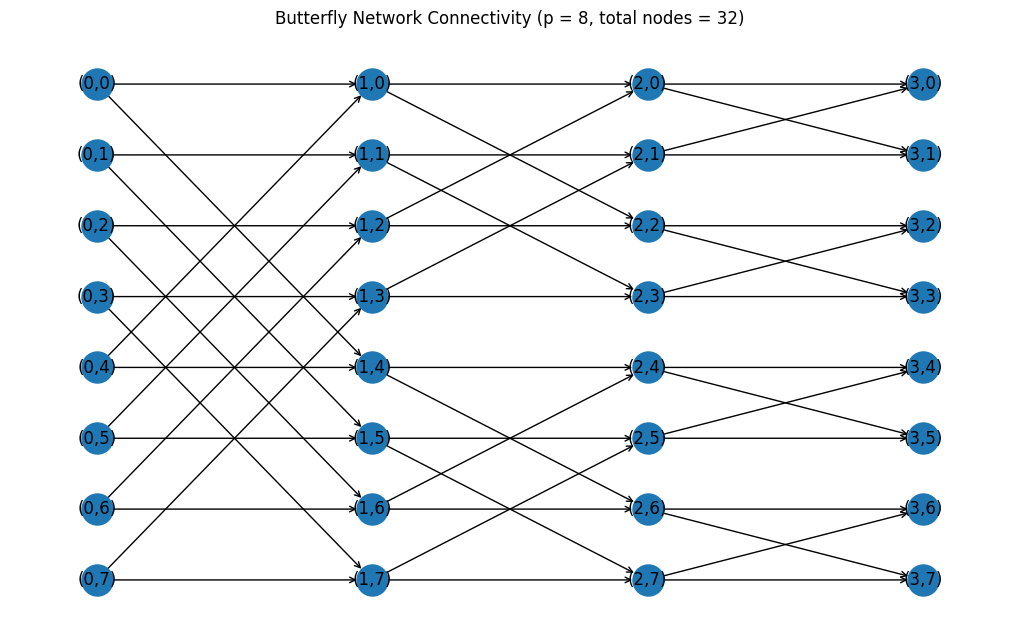

In [41]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import random

# ------------------------------------------------
# Packet class
# ------------------------------------------------
class Packet:
    """
    Packet with a 32-bit route_location (destination), an optional payload,
    and a valid bit.
    """
    def __init__(self, route_location: int, payload=None, valid=True):
        self.route_location = route_location & 0xFFFFFFFF
        self.payload = payload
        self.valid = valid

    def __repr__(self):
        return f"Packet(dest={self.route_location}, payload={self.payload}, valid={self.valid})"

# ------------------------------------------------
# Butterfly Network Simulator
# ------------------------------------------------
class ButterflyNetworkSimulator:
    def __init__(self, p):
        """
        Initialize the butterfly network simulator for p processor nodes.
        p must be a power of 2.
        The network will have L+1 ranks, where L = log2(p).
        Each switching node is identified as (rank, j) with 0 <= j < p.
        """
        if p & (p - 1) != 0:
            raise ValueError("p must be a power of 2.")
        self.p = p
        self.L = int(math.log2(p))  # Number of stages
        self.total_ranks = self.L + 1

    def route_packet(self, packet, src_index):
        """
        Route a single packet injected at node (0, src_index).
        Returns the final node (at rank L) and the complete path taken.
        
        The routing decision at stage i (i = 1..L) is based on the bit at 
        position (L - i) of the packet's destination:
          - Let current node be (i-1, j).  
          - Let desired_bit = (packet.route_location >> (L-i)) & 1.  
          - Let current_bit = (j >> (L-i)) & 1.
          - If current_bit != desired_bit, then flip that bit:
                new_j = j ^ (1 << (L-i))
            Otherwise, new_j remains j.
        The packet then moves to node (i, new_j).
        """
        path = []
        # Start at rank 0. We inject the packet at node (0, src_index).
        current_rank = 0
        current_j = src_index
        path.append((current_rank, current_j))
        
        # Process through ranks 1 to L.
        for i in range(1, self.total_ranks):
            bit_to_check = self.L - i  # which bit position to decide on
            desired_bit = (packet.route_location >> bit_to_check) & 1
            current_bit = (current_j >> bit_to_check) & 1
            if current_bit != desired_bit:
                # Flip the bit at bit_to_check
                current_j = current_j ^ (1 << bit_to_check)
            # Otherwise, current_j remains the same.
            current_rank = i
            path.append((current_rank, current_j))
        return (current_rank, current_j), path

    def route_packets(self, packet_list):
        """
        Route an array of p packets. Assumes packet_list is of length p.
        Returns a list of tuples (packet, final_node, path).
        """
        if len(packet_list) != self.p:
            raise ValueError(f"Expected {self.p} packets, got {len(packet_list)}")
        results = []
        for src_index, packet in enumerate(packet_list):
            final_node, path = self.route_packet(packet, src_index)
            results.append((packet, final_node, path))
        return results

# ------------------------------------------------
# Helper: Generate Butterfly Network Connectivity (for visualization)
# ------------------------------------------------
def generate_butterfly_network(p):
    """
    Generate a butterfly network graph based on the following rule:
    For any node N(i, j) with i > 0, it is connected from:
      - N(i-1, j)
      - N(i-1, m), where m is obtained by flipping the bit at position (L-i) of j.
    """
    L = int(math.log2(p))
    total_ranks = L + 1
    G = nx.DiGraph()
    
    # Add all switching nodes: nodes are labeled as (rank, j)
    for i in range(total_ranks):
        for j in range(p):
            node = (i, j)
            G.add_node(node, label=f"({i},{j})")
    
    # For every node in rank i>0, add edges from N(i-1,j) and N(i-1, m)
    for i in range(1, total_ranks):
        for j in range(p):
            flip_bit = 1 << (L - i)
            m = j ^ flip_bit
            G.add_edge((i-1, j), (i, j))
            G.add_edge((i-1, m), (i, j))
    return G

def draw_butterfly_network(G, p):
    """
    Draw the butterfly network graph G with a layered layout.
    """
    pos = {}
    total_ranks = int(math.log2(p)) + 1
    for (i, j) in G.nodes():
        pos[(i, j)] = (i, -j)
    
    labels = nx.get_node_attributes(G, 'label')
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=500,
            arrowstyle="->", arrowsize=10)
    plt.title(f"Butterfly Network Connectivity (p = {p}, total nodes = {p * (total_ranks)})")
    plt.xlabel("Rank")
    plt.ylabel("Column (j)")
    plt.show()

# ------------------------------------------------
# Example: Simulate Routing in a Butterfly Network for p = 8
# ------------------------------------------------
if __name__ == "__main__":
    p = 8
    simulator = ButterflyNetworkSimulator(p)
    
    # Create a permutation of destinations.
    # For a valid permutation routing, we want one packet destined to each processor (0 to p-1).
    destinations = list(range(p))
    random.shuffle(destinations)  # random permutation
    packets = [Packet(route_location=d, payload=f"Data_from_{i}") for i, d in enumerate(destinations)]
    
    print("Input Packets:")
    for i, pkt in enumerate(packets):
        print(f"  Injected at node (0,{i}): {pkt}")
    
    results = simulator.route_packets(packets)
    
    print("\nRouting Results:")
    for pkt, final_node, path in results:
        print(f"Packet destined for {pkt.route_location} routed along path: {path} --> Final Node: {final_node}")
    
    # Optionally, visualize the network connectivity.
    G = generate_butterfly_network(p)
    draw_butterfly_network(G, p)
